In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [4]:
cols2zscore = cols2zscore.drop('residual sugar')

dataT = torch.tensor( data[cols2zscore].values ).float()
sugar = torch.tensor( data['residual sugar'].values ).float()
sugar = sugar[:,None]

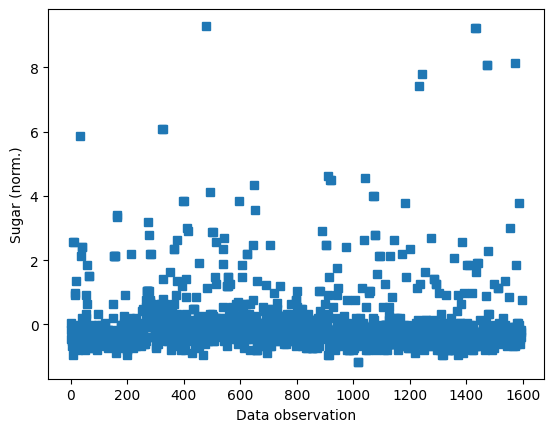

In [5]:
plt.plot(sugar,'s')
plt.xlabel('Data observation')
plt.ylabel('Sugar (norm.)')
plt.show()

In [7]:
train_dataSK,test_dataSK, train_labelsSK,test_labelsSK = train_test_split(dataT, sugar, test_size=.1)

train_dataDataset = torch.utils.data.TensorDataset(train_dataSK,train_labelsSK)
test_dataDataset  = torch.utils.data.TensorDataset(test_dataSK,test_labelsSK)

batchsize    = 32
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [11]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11,16)
        self.hl1 = nn.Linear(16,32)
        self.hl2 = nn.Linear(32,32)
        self.output = nn.Linear(32,1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hl1(x))
        x = F.relu(self.hl2(x))
        return self.output(x)

In [12]:
numEpochs = 1000

def trainTheModel():
    trainLoss = torch.zeros(numEpochs)
    testLoss = torch.zeros(numEpochs)

    lossfun = nn.MSELoss()
    optimizer = torch.optim.SGD(params=winenet.parameters(), lr=0.01)

    for epochi in range(numEpochs):
        winenet.train()

        batchLoss = []

        for X,y in train_loader:
            yHat = winenet(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        trainLoss[epochi] = np.mean(batchLoss)
        winenet.eval()
        X,y = next(iter(test_loader))

        with torch.no_grad():
            yHat = winenet(X)
        testLoss[epochi] = lossfun(yHat,y).item()

    return trainLoss, testLoss

In [13]:
winenet = ANNwine()
trainLoss, testLoss = trainTheModel()

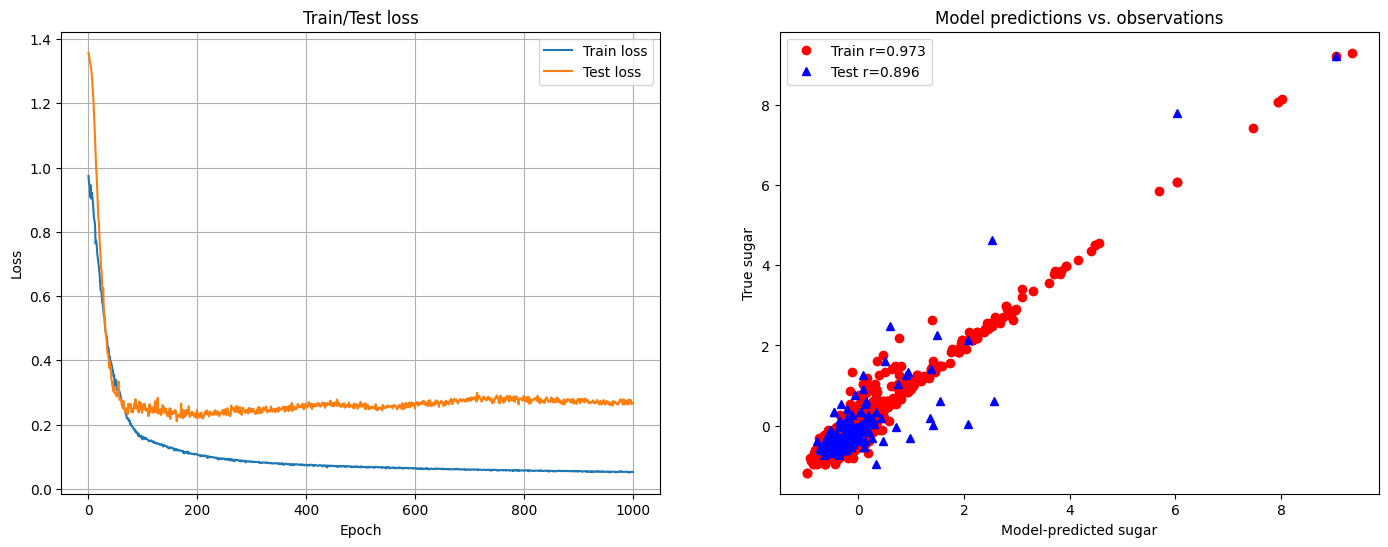

In [14]:
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

yHatTrain = winenet(train_dataSK)
yHatTest  = winenet(test_dataSK)

ax[1].plot(yHatTrain.detach(),train_labelsSK,'ro')
ax[1].plot(yHatTest.detach(),test_labelsSK,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelsSK.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelsSK.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()

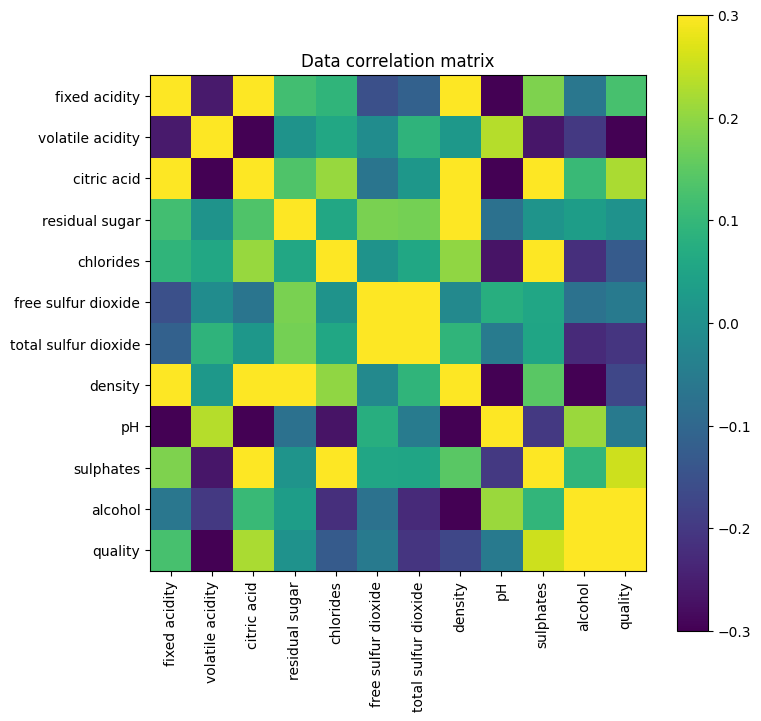

In [15]:
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()